In [5]:
import ROOT
ROOT.gErrorIgnoreLevel = ROOT.kWarning
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import matplotlib.ticker as ticker
import pandas as pd
import mplhep as hep
from utils import *

In [6]:
filename = 'data/SC4njets0_python.root'
chain = ROOT.TChain("Events")
chain.Add(filename)

1

In [7]:
pt_bins = np.linspace(0, 60, 26)
delta_r_threshold = 0.4
eta_condition_barrel = lambda eta: np.abs(eta) < 1.52
eta_condition_endcap = lambda eta: (np.abs(eta) >= 1.52) & (np.abs(eta) < 2.4)

In [8]:
matched_unmatched = {}
matched_unmatched["Ak4PFJets"] = match_reco_to_gen(chain, "L1PFJets", "GenVisTaus")
matched_unmatched["ScoutPFTaus"] = match_reco_to_gen(chain, "ScoutPFTaus", "GenVisTaus")
matched_unmatched["NNPuppiTaus"] = match_reco_to_gen(chain, "L1nnPuppiTaus", "GenVisTaus")
matched_unmatched["NNPuppiTaus_nocut"] = match_reco_to_gen(chain, "L1nnPuppiTaus", "GenVisTaus", nnPuppiTauscut = False)

In [9]:
eff_barrel = {}
ak4pfb = compute_efficiency_from_matches(matched_unmatched["Ak4PFJets"][0], chain, eta_condition = eta_condition_barrel)
total_gen_per_bin_b = ak4pfb[-1]
pt_centers = ak4pfb[0]
eff_barrel["Ak4PFJets"] = ak4pfb[0:3]
eff_barrel["NNPuppiTaus"] = compute_efficiency_from_matches(matched_unmatched["NNPuppiTaus"][0], chain)[0:3]
eff_barrel["NNPuppiTaus_nocut"] = compute_efficiency_from_matches(matched_unmatched["NNPuppiTaus_nocut"][0], chain)[0:3]
eff_barrel["ScoutPFTaus"] = compute_efficiency_from_matches(matched_unmatched["ScoutPFTaus"][0], chain)[0:3]

/eos/home-i03/v/vcamagni/SeededCone_tuning/utils.py:283: RuntimeWarning: invalid value encountered in divide
  errors = np.sqrt(efficiency * (1 - efficiency) / total_gen_per_bin,


In [10]:
eff_endcap = {}
ak4pfe = compute_efficiency_from_matches(matched_unmatched["Ak4PFJets"][0], chain, eta_condition = eta_condition_endcap)
total_gen_per_bin_e = ak4pfe[-1]
eff_endcap["Ak4PFJets"] = ak4pfe[0:3]
eff_endcap["NNPuppiTaus"] = compute_efficiency_from_matches(matched_unmatched["NNPuppiTaus"][0], chain, eta_condition = eta_condition_endcap)[0:3]
eff_endcap["NNPuppiTaus_nocut"] = compute_efficiency_from_matches(matched_unmatched["NNPuppiTaus_nocut"][0], chain, eta_condition = eta_condition_endcap)[0:3]
eff_endcap["ScoutPFTaus"] = compute_efficiency_from_matches(matched_unmatched["ScoutPFTaus"][0], chain, eta_condition = eta_condition_endcap)[0:3]

In [11]:
markers = ['o', 's', 'v', 'v']
mfc = ["red", "none", "orange", "green"]
colors = ["red", "orange", "orange", "green",]
labs = ["AK4PFJets RECO", "NNPuppiTaus ID", "NNPuppiTaus RECO",  "SeededCone RECO"]

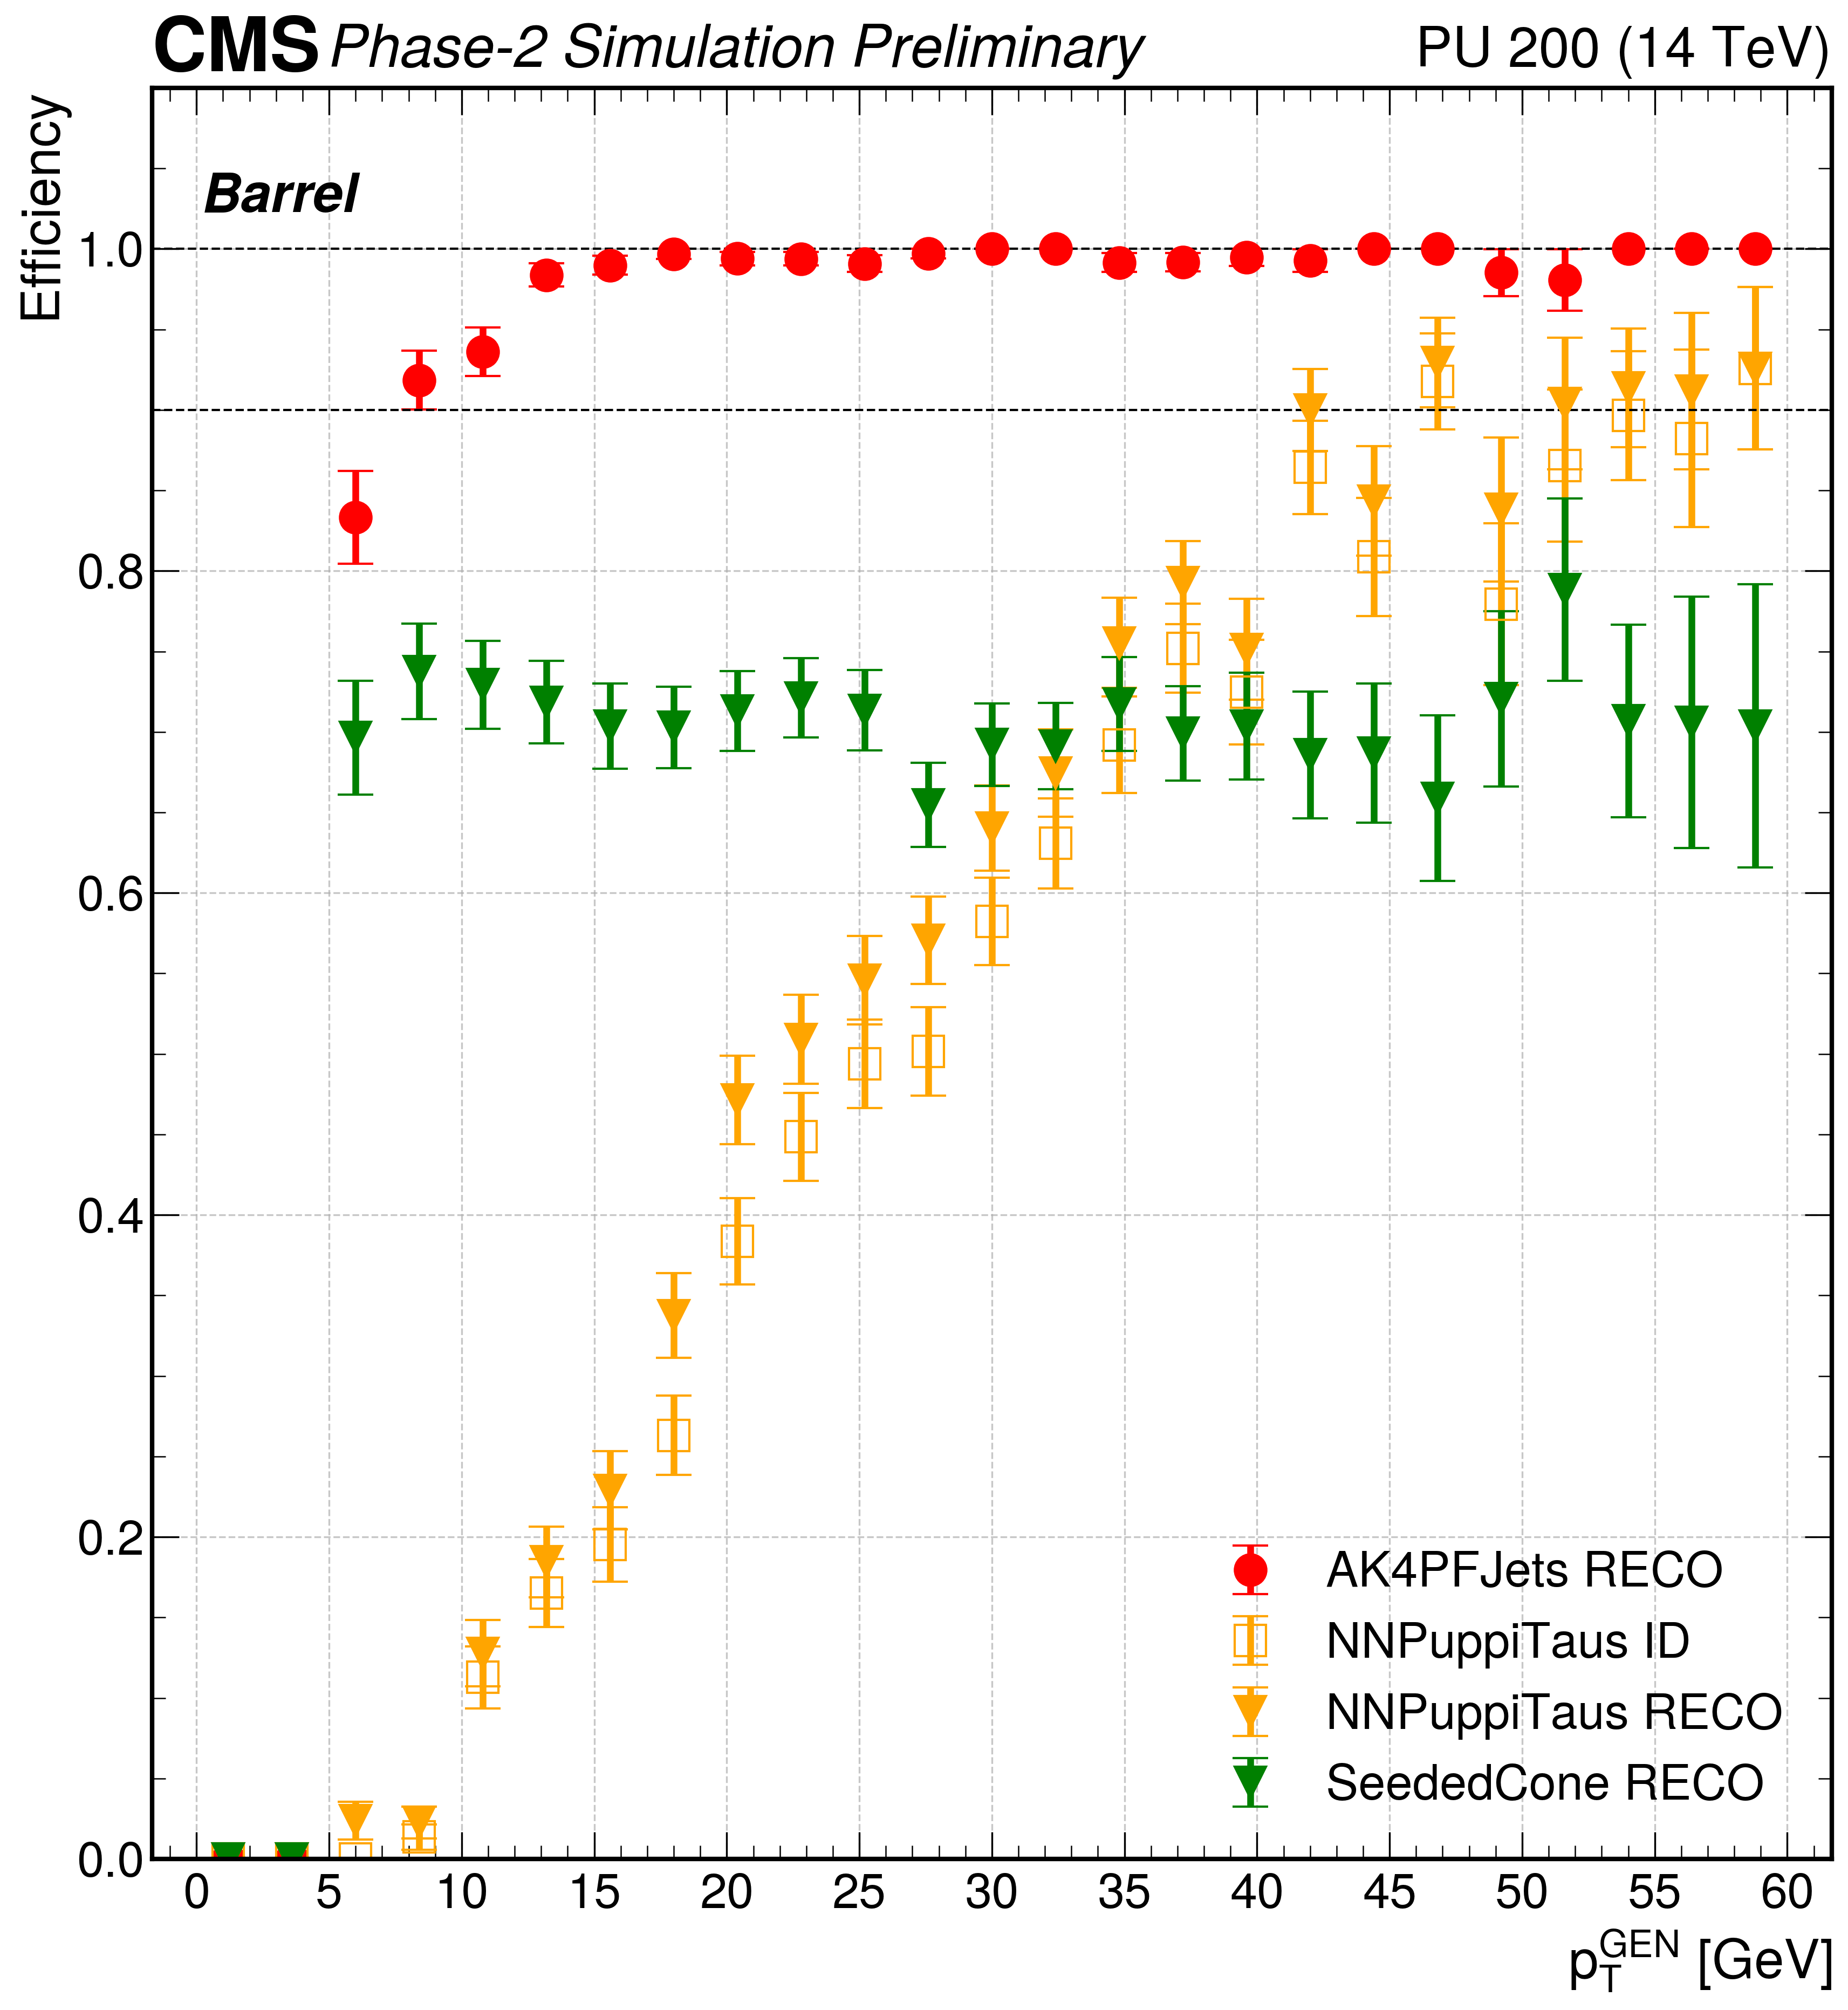

In [14]:
plot_efficiencies_single_region(
    eff_barrel,
    pt_bins,
    'Barrel',
    'plots/eff_barrel.png',
    True,
    markers,
    mfc,
    colors,
    labs
)

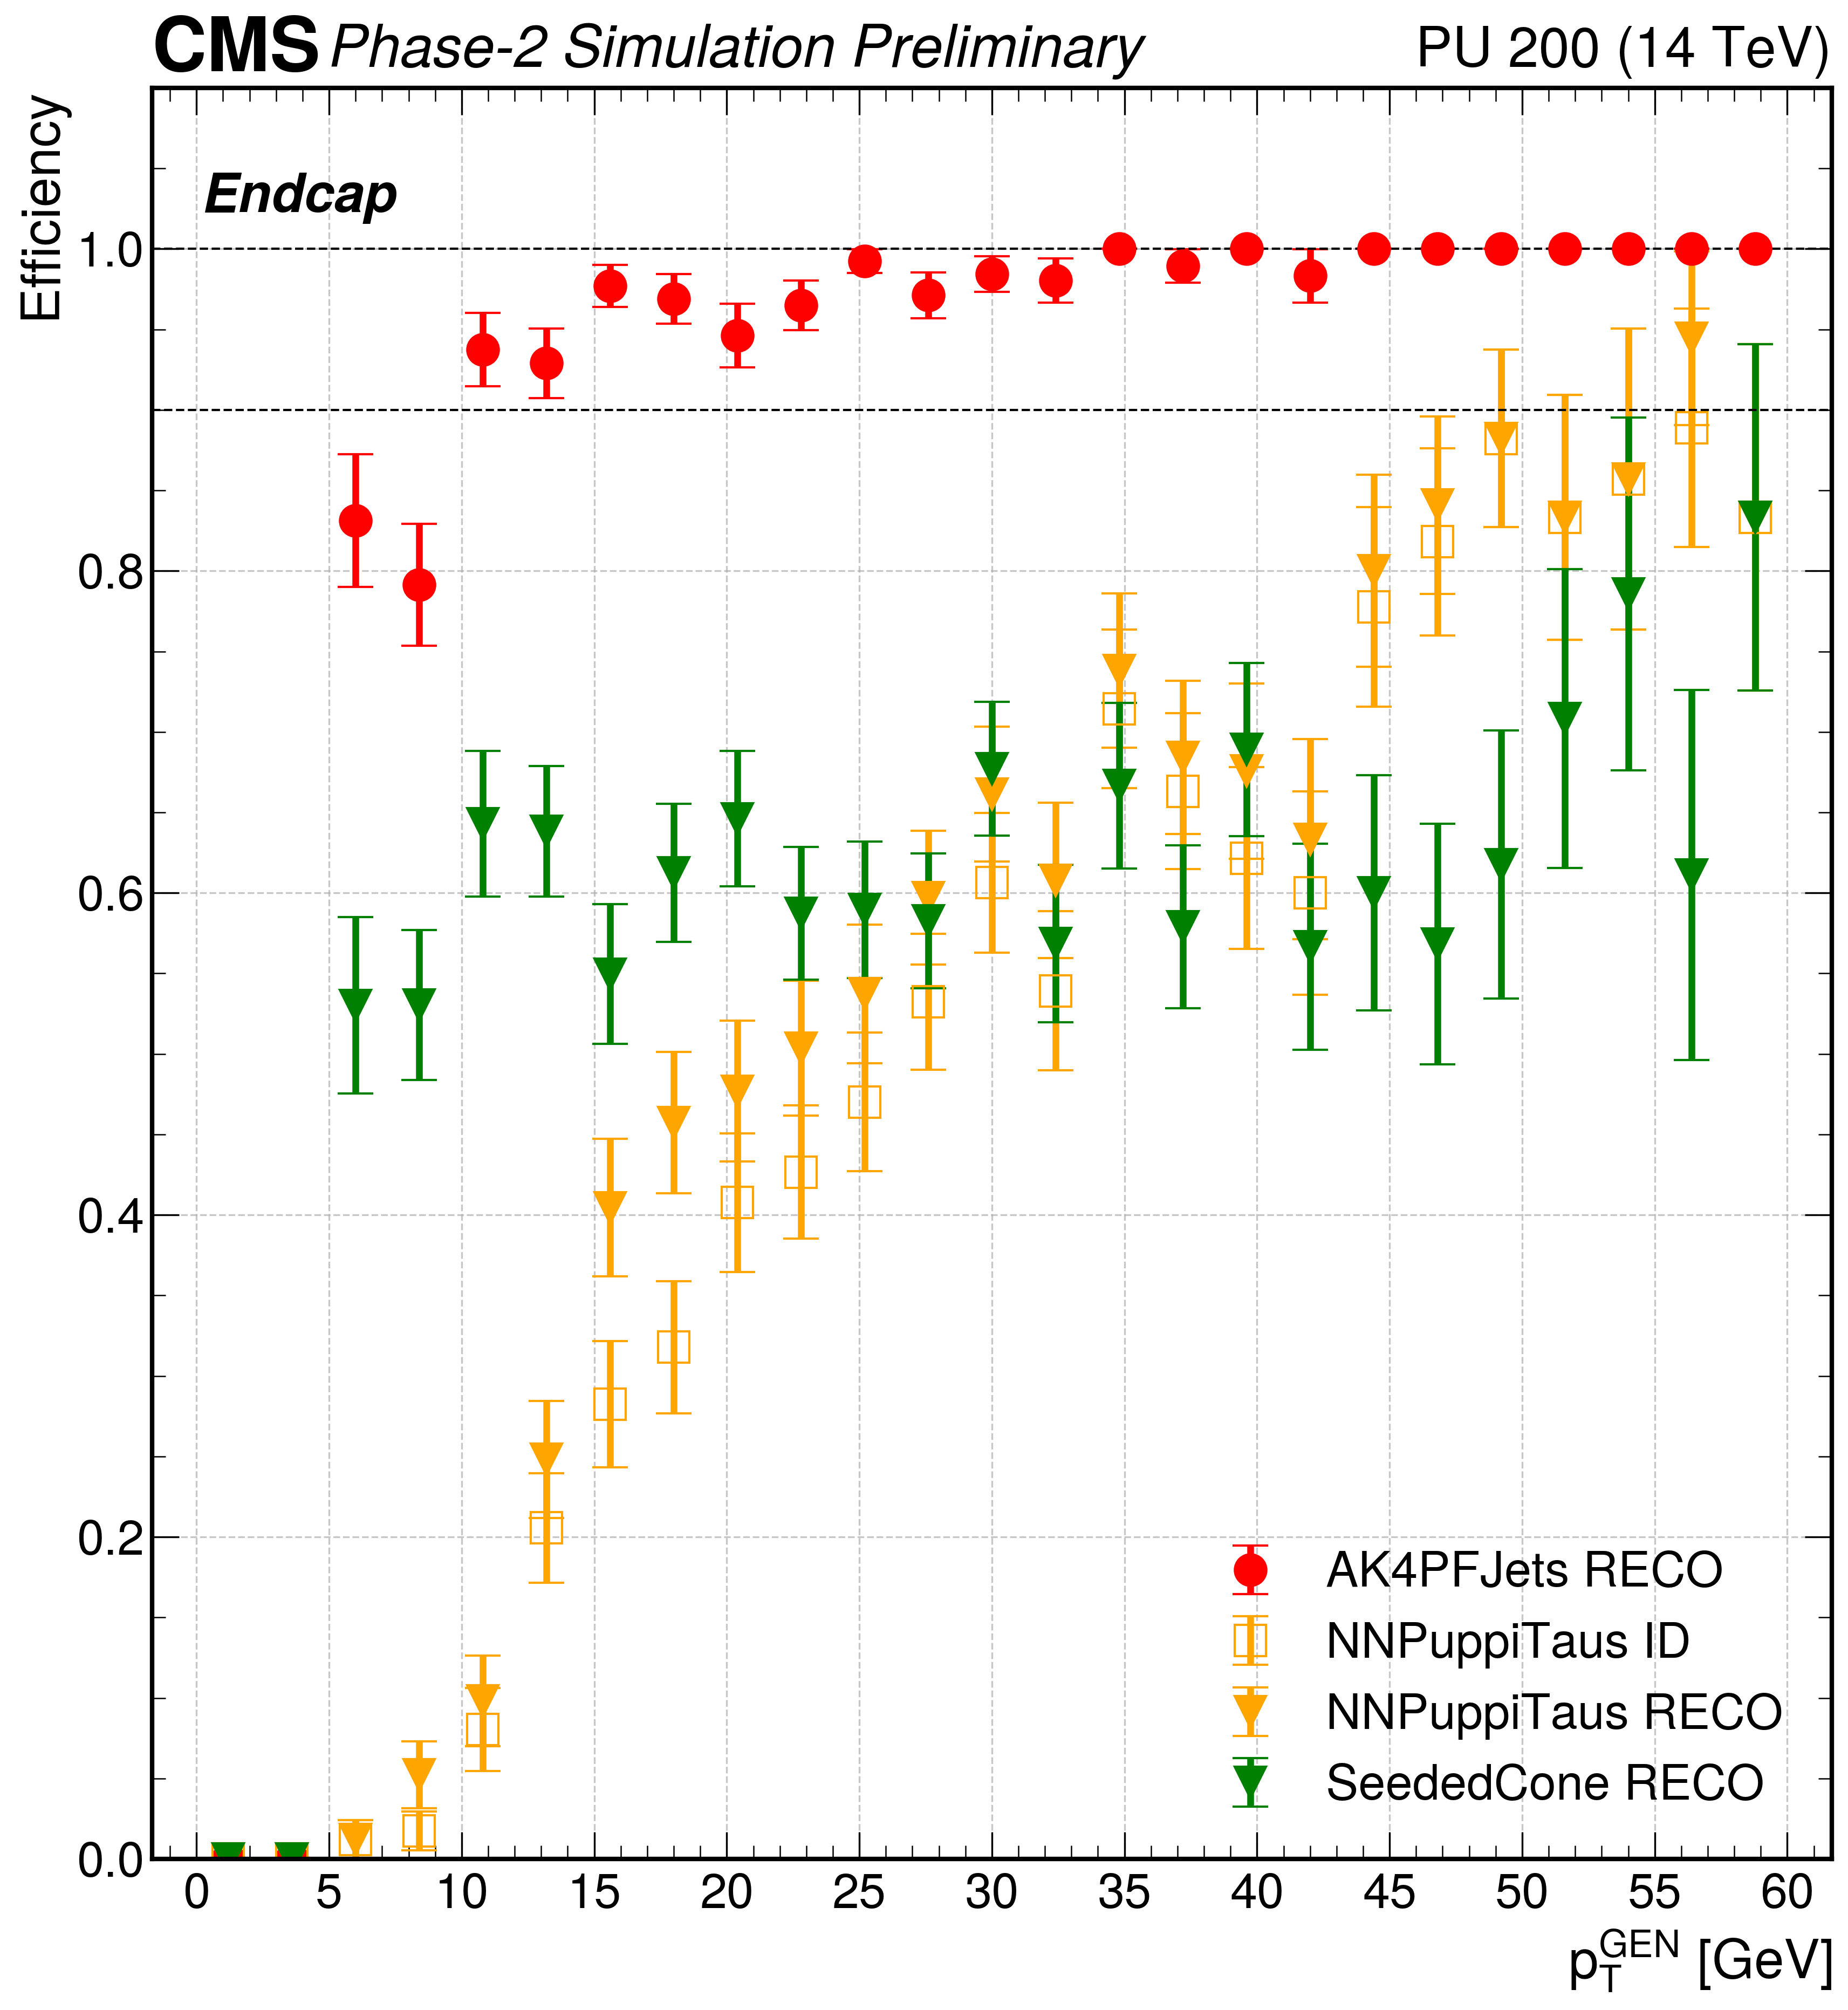

In [13]:
plot_efficiencies_single_region(
    eff_endcap,
    pt_bins,
    'Endcap',
    'plots/eff_endcap.png',
    True,
    markers,
    mfc,
    colors,
    labs
)

In [15]:
sc_counts = count_reco_in_cone(chain, "ScoutPFTaus")
ak4_counts = count_reco_in_cone(chain, "L1PFJets")

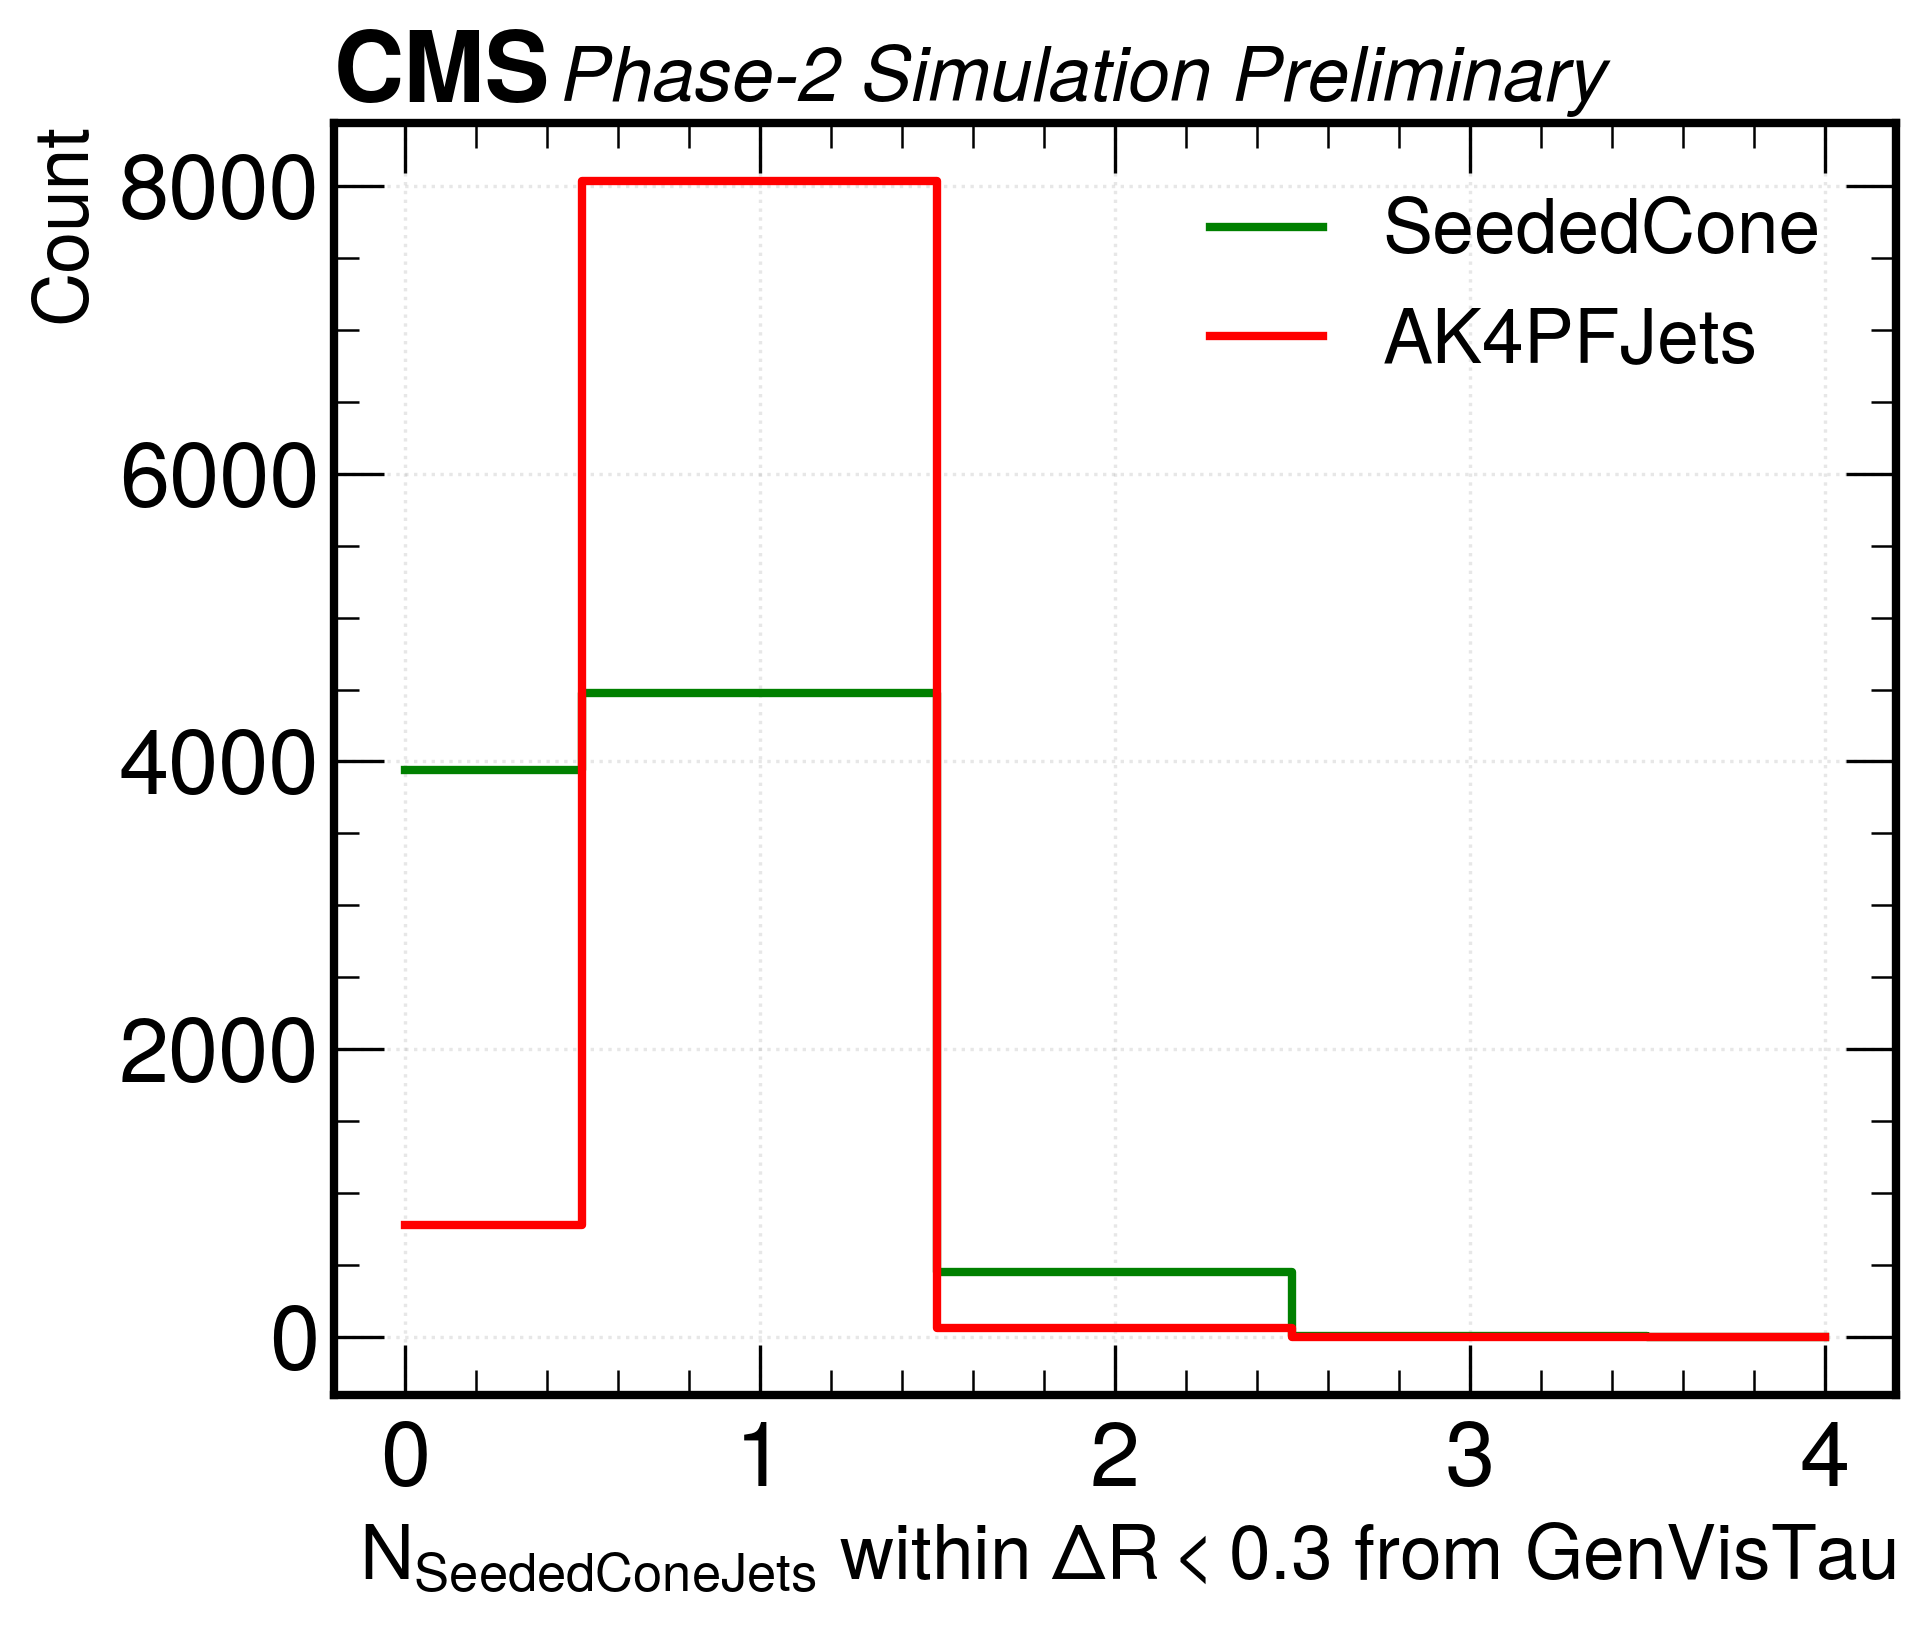

In [16]:
hep.style.use("CMS") 

bins = np.arange(0, 6, 1)

plt.figure(figsize=(7,6), dpi = 300)

# SeededCone
plt.step(bins[:-1], np.histogram(sc_counts, bins=bins)[0],
         where='mid', linewidth=2, label="SeededCone", color='green')

# AK4
plt.step(bins[:-1], np.histogram(ak4_counts, bins=bins)[0],
         where='mid', linewidth=2, label="AK4PFJets", color='red')

plt.xlabel(r"$N_{\mathrm{SeededConeJets}}$ within $\Delta R < 0.3$ from GenVisTau", fontsize = 18)
plt.ylabel("Count", fontsize = 18)

plt.legend(fontsize = 18)
hep.cms.text("Phase-2 Simulation Preliminary", fontsize = 18)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('plots/count_recotaus.png', dpi = 300)
plt.show()

In [17]:
ev_n = 471
event = chain
chain.GetEntry(ev_n)

75378

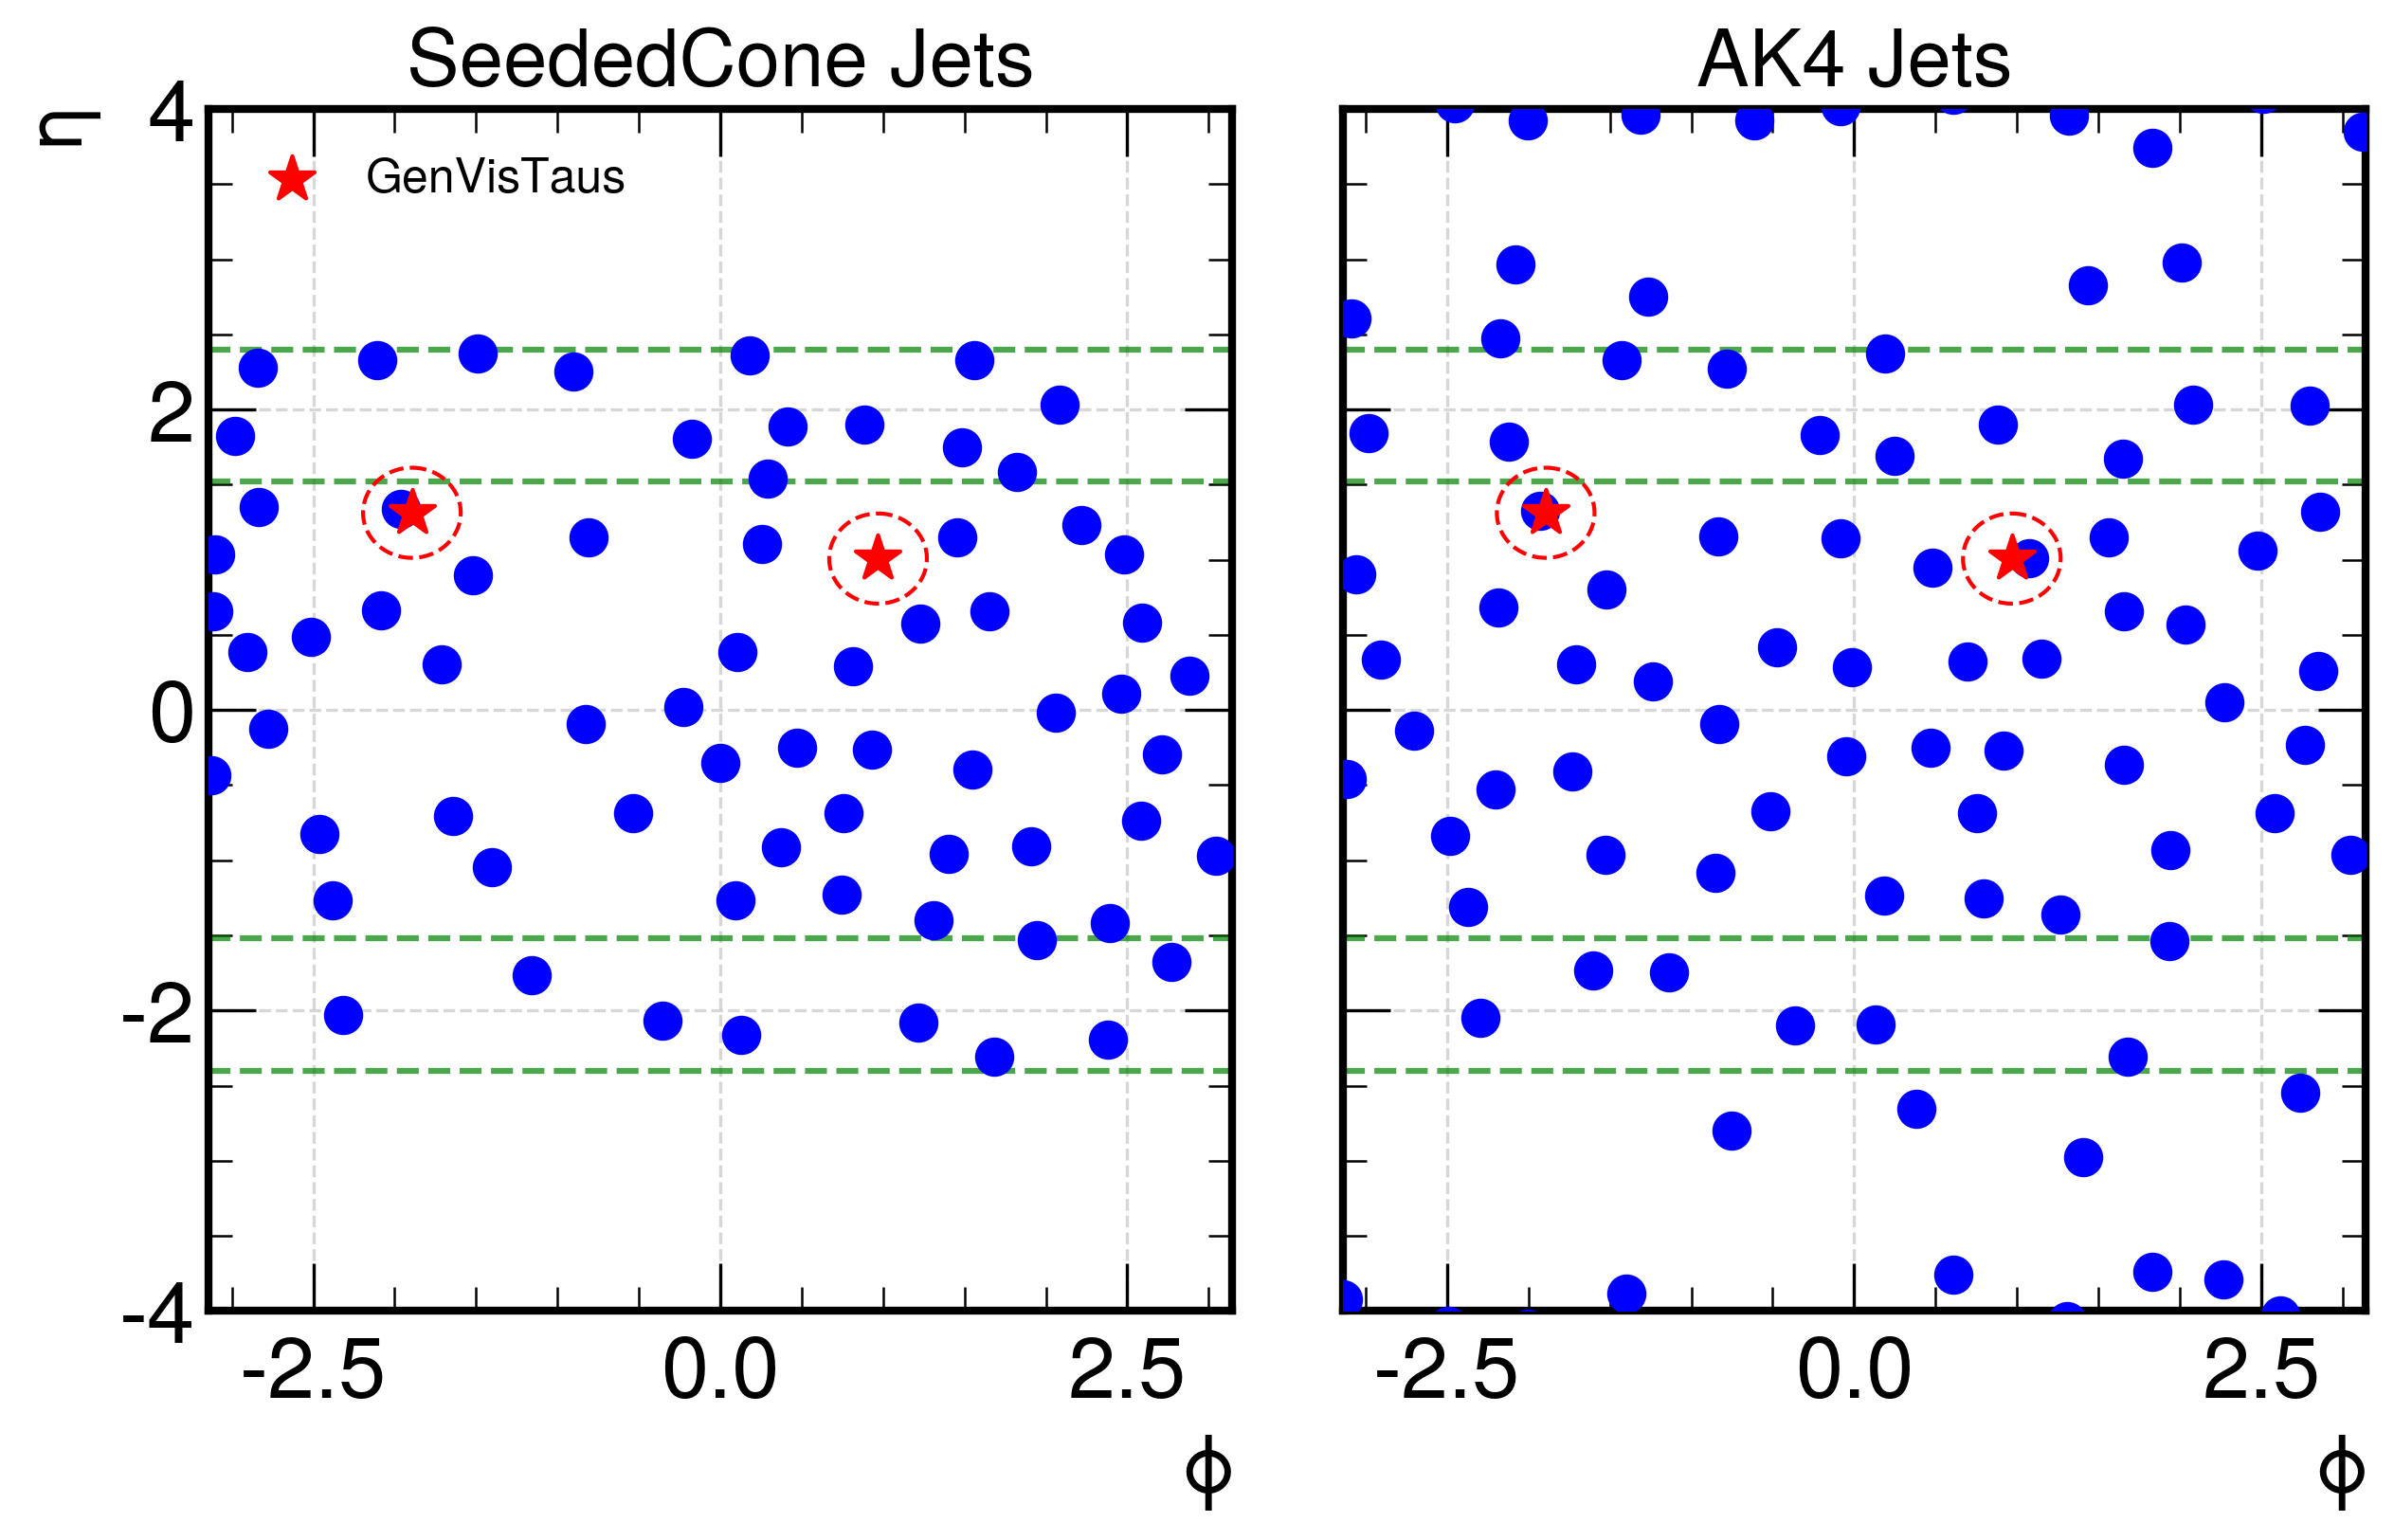

In [18]:
plot_event_eta_phi_with_cone(
    event, outputfile = f"plots/sc_vs_ak4_event_{ev_n}.png",
    gen_key="GenVisTaus",
    reco_keys=("ScoutPFTaus", "L1PFJets"),
    titles=("SeededCone Jets", "AK4 Jets"),
    R=0.3
)

In [19]:
plot_pf_clusters_event(event, f'plots/pf_sc_event_{ev_n}.html',
                       pf_eta_key="L1PF_eta",
                       pf_phi_key="L1PF_phi",
                       pf_pt_key="L1PF_pt",
                       pf_pdgId_key="L1PF_pdgId",
                       pf_seed_key="SC4AlpakaClusters_is_seed",
                       cluster_key="SC4AlpakaClusters_cluster",
                       gen_key="GenVisTaus",
                       reco_key="ScoutPFTaus",
                       R=0.3,
                       title="PF Candidates colored by cluster - SeededCone Jets")

In [20]:
# ---------------------------
# Jet collection
# ---------------------------
jet_key = "L1PFJets"
gen_key = "GenVisTaus"
R = 0.3
max_dau = 16

jet_pt  = np.array(getattr(event, f"{jet_key}_pt"))
jet_eta = np.array(getattr(event, f"{jet_key}_eta"))
jet_phi = wrap_phi(np.array(getattr(event, f"{jet_key}_phi")))

n_jets = len(jet_pt)
colors = [f"hsl({int(360*i/max(n_jets,1))},70%,50%)" for i in range(n_jets)]

fig = go.Figure()

# ---------------------------
# Gen taus + ΔR cones
# ---------------------------
gen_eta = np.array(getattr(event, f"{gen_key}_eta"))
gen_phi = wrap_phi(np.array(getattr(event, f"{gen_key}_phi")))
gen_pt  = np.array(getattr(event, f"{gen_key}_pt"))

theta = np.linspace(0, 2*np.pi, 300)

for eta0, phi0, pt0 in zip(gen_eta, gen_phi, gen_pt):

    fig.add_trace(go.Scatter(
        x=wrap_phi(phi0 + R*np.sin(theta)),
        y=eta0 + R*np.cos(theta),
        mode="lines",
        line=dict(color="red", dash="dot", width=2),
        name="ΔR = 0.3",
        showlegend=False
    ))

    fig.add_trace(go.Scatter(
        x=[phi0],
        y=[eta0],
        mode="markers",
        marker=dict(size=16, color="red", symbol="star"),
        name="GenVisTau",
        customdata=np.array([[pt0]]),
        hovertemplate=(
            "GenVisTau<br>"
            "η = %{y:.3f}<br>"
            "φ = %{x:.3f}<br>"
            "pT = %{customdata[0]:.2f} GeV<br>"
            "<extra></extra>"
        )
    ))

# ---------------------------
# Jets + daughters
# ---------------------------
for j in range(n_jets):

    col = colors[j]

    # --- Jet
    fig.add_trace(go.Scatter(
        x=[jet_phi[j]],
        y=[jet_eta[j]],
        mode="markers",
        marker=dict(size=18, color="blue", symbol="circle"),
        showlegend=False,
        customdata=np.array([[jet_pt[j]]]),
        hovertemplate=(
            f"Jet {j}<br>"
            "η = %{y:.3f}<br>"
            "φ = %{x:.3f}<br>"
            "pT = %{customdata[0]:.2f} GeV<br>"
            "<extra></extra>"
        )
    ))

    # --- Daughters 
    dau_eta, dau_phi, dau_pt, dau_pdg = [], [], [], []

    for d in range(max_dau):
        pt = getattr(event, f"{jet_key}_dau{d}_pt")[j]
        if pt <= 0:
            continue

        dau_pt.append(pt)
        dau_eta.append(getattr(event, f"{jet_key}_dau{d}_eta")[j])
        dau_phi.append(getattr(event, f"{jet_key}_dau{d}_phi")[j])
        dau_pdg.append(getattr(event, f"{jet_key}_dau{d}_pdgId")[j])

    if dau_pt:
        fig.add_trace(go.Scatter(
            x=wrap_phi(np.array(dau_phi)),
            y=np.array(dau_eta),
            mode="markers",
            marker=dict(size=8, color=col),
            showlegend=False,
            customdata=np.stack([dau_pt, dau_pdg], axis=-1),
            hovertemplate=(
                f"Cluster {j}<br>"
                "η = %{y:.3f}<br>"
                "φ = %{x:.3f}<br>"
                "pT = %{customdata[0]:.2f} GeV<br>"
                "pdgId = %{customdata[1]}<br>"
                "<extra></extra>"
            )
        ))

for j in range(n_jets):
    fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode="markers",
        marker=dict(size=10, color=colors[j]),
        name=f"Cluster {j}",
        showlegend=True
    ))

fig.update_layout(
    title="PF Candidates colored by cluster - AK4 Jets",
    yaxis=dict(title="η", range=[-3, 3], scaleanchor="x", scaleratio=1),
    xaxis=dict(title="φ", range=[-np.pi, np.pi]),
    width=900,
    height=900,
    legend=dict(itemsizing="constant")
)

fig.write_html(f'plots/pf_ak4_event_{ev_n}.html')
fig.show()
